# Classifying a book into different genres based on the it's cover using Keras
This notebook demonstrates how to use a Keras model to classify a book into different genres based on the cover of the book.

The training data was collected from Goodreads' best books ever list found here: https://www.goodreads.com/list/show/1.Best_Books_Ever.
The test data used to validate the model was collected from the list of best books of 2018, found here: https://www.goodreads.com/list/best_of_year/2018?id=119307.Best_books_of_2018

## Exploratory data analysis (EDA)
This section of the notebook explores the data collected from Goodreads on a large number of books. We will look at the various attributes to frame a problem statement at the end to work on. 

### Setting up the environment
Importing all the required packages. 


In [0]:
import pandas as pd
import numpy as np

import cufflinks as cf
cf.go_offline()
from collections import defaultdict

from google.colab import files

We define a function, 'configure_plotly_browser_state'. This function is required to see Plotly charts in colab. We need to call this function in every cell where a Plotly chart gets drawn.

In [0]:
def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.43.1.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
from glob import glob
glob("/tmp/Images/Testing/*/")
  

['/tmp/Images/Testing/Mystery-Crime/',
 '/tmp/Images/Testing/Business/',
 '/tmp/Images/Testing/Sports/',
 '/tmp/Images/Testing/Graphic-Novels-Comics/',
 '/tmp/Images/Testing/Biography-History/',
 '/tmp/Images/Testing/Art-Architecture-Photography/',
 '/tmp/Images/Testing/Lifestyle/',
 '/tmp/Images/Testing/Science-Fiction-Fantasy/',
 '/tmp/Images/Testing/Fiction/',
 '/tmp/Images/Testing/Religion/']

In [0]:
genre_list = []
import os
for root, dirs, files in os.walk("/tmp/Images/Training"):
    for dir1 in dirs:
        genre_list.append(dir1)
        

In [0]:
for direc in genre_list:
  list = os.listdir('/tmp/Images/Training/'+direc) 

In [0]:
fin_list = []
for direc in genre_list:
  list = os.listdir('/tmp/Images/Training/'+direc) 
  number_files = len(list)
  fin_list.append((direc, number_files))


In [0]:
import pandas as pd
gen = pd.DataFrame(fin_list, columns=['Genre','Count'])

In [0]:
gen

,Genre,Count
0,Mystery-Crime,175
1,Business,175
2,Sports,169
3,Graphic-Novels-Comics,175
4,Biography-History,317
5,Art-Architecture-Photography,170
6,Lifestyle,331
7,Science-Fiction-Fantasy,175
8,Fiction,174
9,Religion,175


### Importing Relevant Libraries

In [0]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import os

### Setting up Inception V3 model for Transfer Learning
Inception v3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. 

The model itself is made up of symmetric and asymmetric building blocks, including convolutions, average pooling, max pooling, concats, dropouts, and fully connected layers. Batchnorm is used extensively throughout the model and applied to activation inputs. Loss is computed via Softmax.

In [0]:
path_inception = "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = path_inception

pre_trained_model = InceptionV3(input_shape= (150,150,3),
                               include_top = False,
                               weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
    

In [0]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [0]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape', last_layer.output_shape)
last_output = last_layer.output

last layer output shape (None, 7, 7, 768)


In [0]:
#Ending training once we reach 97% accuracy
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy') > 0.97):
            print("\nReached 97% accuracy so cancelling training!")
            self.model.stop_training = True

### Build the model

In [0]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(10, activation = 'softmax')(x)

model = Model(pre_trained_model.input,x)

model.compile(optimizer = RMSprop(lr = 0.0001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

### Import scrapped images and stage them in tmp folder

In [0]:
import zipfile
local_zip = 'Images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
test_dir = '/tmp/Images/Testing'
train_dir = '/tmp/Images/Training'

### Add our data-augmentation parameters to ImageDataGenerator

In [0]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size = 20,
                                                   class_mode = 'categorical',
                                                   target_size = (150,150))     

test_generator =  test_datagen.flow_from_directory(test_dir,
                                                        batch_size = 20,
                                                        class_mode = 'categorical',
                                                        target_size = (150,150))


Found 2036 images belonging to 10 classes.
Found 294 images belonging to 10 classes.


### Training the Model
Train the model by slicing the data, and repeatedly iterating over the entire dataset for a given number of "epochs"

In [0]:
callbacks = myCallback()
history = model.fit(train_generator,
                              validation_data = test_generator,
                              steps_per_epoch = 125,
                              epochs = 100,
                              verbose = 2,
                              validation_steps = 50,
                              callbacks = [callbacks])

Epoch 1/100
125/125 - 19s - loss: 2.1233 - accuracy: 0.2548 - val_loss: 1.9444 - val_accuracy: 0.2841
Epoch 2/100
125/125 - 18s - loss: 1.8398 - accuracy: 0.3578 - val_loss: 1.9784 - val_accuracy: 0.2872
Epoch 3/100
125/125 - 17s - loss: 1.7537 - accuracy: 0.3694 - val_loss: 2.0444 - val_accuracy: 0.2900
Epoch 4/100
125/125 - 17s - loss: 1.6466 - accuracy: 0.4067 - val_loss: 2.0174 - val_accuracy: 0.3350
Epoch 5/100
125/125 - 17s - loss: 1.6241 - accuracy: 0.4406 - val_loss: 2.0117 - val_accuracy: 0.3381
Epoch 6/100
125/125 - 17s - loss: 1.5540 - accuracy: 0.4523 - val_loss: 1.9353 - val_accuracy: 0.3157
Epoch 7/100
125/125 - 17s - loss: 1.5137 - accuracy: 0.4595 - val_loss: 2.0079 - val_accuracy: 0.3360
Epoch 8/100
125/125 - 17s - loss: 1.4467 - accuracy: 0.4836 - val_loss: 1.9646 - val_accuracy: 0.3402
Epoch 9/100
125/125 - 17s - loss: 1.4358 - accuracy: 0.4936 - val_loss: 1.9235 - val_accuracy: 0.3330
Epoch 10/100
125/125 - 17s - loss: 1.3812 - accuracy: 0.5140 - val_loss: 1.9484 - 

### Visualization
Visualize the model accuracy and loss over the duration of training using matplotlib

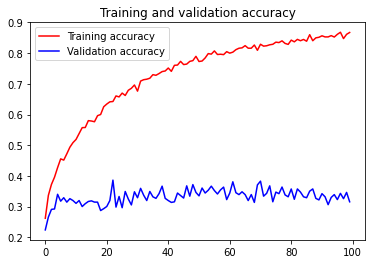

<Figure size 432x288 with 0 Axes>

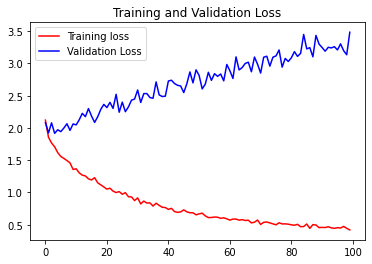

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc = 0)
plt.figure()
plt.show()

### Evaluate the model
Evaluate the model on the test data using `evaluate`

In [0]:
print('\n# Evaluate on test data')
results = model.evaluate(test_generator, batch_size=1)


# Evaluate on test data
  62299/Unknown - 7757s 125ms/step - loss: 0.3493 - accuracy: 0.8858Buffered data was truncated after reaching the output size limit.

### Pickle the model 
We save the model as 'model.h5' 

In [0]:
from keras.models import load_model

In [0]:
model.save('model.h5')

### What Next?
We've used the pickled model to create a flask app which would take in an image (book cover) as input and classify the image in a genre.